In [99]:
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
import pandas as pd
import plotly.express as px

In [100]:
# data = pdr.get_data_yahoo("", start="2000-01-01", end="2023-01-01")

In [101]:
# data.to_csv('AAPL.csv')

In [102]:
data = pd.read_csv('AAPL.csv')
raw_data = data.copy()

In [103]:
px.line(data, x='Date', y='Close')

In [238]:
import pandas as pd
import numpy as np

def apply_npmm_labeling(df, column_name='Close', window_size=10):
    """
    Apply NPMM (N-Period Max-Min) labeling to a pandas DataFrame.

    Parameters:
    - df: pandas DataFrame containing the time series data.
    - column_name: Name of the column containing the time series data to be labeled. Default is 'Close'.
    - window_size: The size of the rolling window for labeling. Default is 10.

    Returns:
    - Labeled DataFrame.
    """

    # Initialize a new column for the label
    df['Label'] = None

    # Loop through the DataFrame to find local maxima and minima
    for i in range(0, len(df) - window_size + 1):
        window = df.loc[i:i+window_size-1, column_name]

        # Find local maximum and minimum in the window
        local_max = window.max()
        local_min = window.min()

        # Check where the local maximum and minimum occur in the window
        max_index = window[window == local_max].index[0]
        min_index = window[window == local_min].index[0]

        # Label the points
        df.loc[max_index, 'Label'] = 0  # 0 for maximum points
        df.loc[min_index, 'Label'] = 1  # 1 for minimum points

    return df

# Apply NPMM labeling
labeled_df = apply_npmm_labeling(data, 'Close', 30)
# labeled_df['Label'] = labeled_df['Label'].shift(-1)

In [239]:
fig = px.scatter(labeled_df, x='Date', y='Close', color='Label')
# add a line plot to the scatter plot of the Close price
fig.add_trace(px.line(labeled_df, x='Date', y='Close').data[0])

In [106]:
def create_signals(labeled_df):
    prev = None
    prevind = None
    signals = [None] * len(labeled_df['Label'])
    for (i, val) in enumerate(labeled_df['Label']):
        if prev is None and val is not None:
            prev = val
            prevind = i
        if val is None:
            continue
        if prev == 1 and val == 0:
            signals[prevind] = 'Buy'
        if prev == 0 and val == 1:
            signals[prevind] = 'Sell'
        if val is not None:
            prev = val
            prevind = i
    return signals

In [107]:
labeled_df = apply_npmm_labeling(data, 'Close', 14)
labeled_df['Signal'] = create_signals(labeled_df)

In [108]:
labeled_df

,Date,Open,High,Low,Close,Adj Close,Volume,Label,Signal
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.848323,535796800,None,None
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.776801,512377600,None,None
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.788168,778321600,None,None
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719961,767972800,None,None
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.754065,460734400,None,None
...,...,...,...,...,...,...,...,...,...
5782,2022-12-23,130.919998,132.419998,129.639999,131.860001,131.299820,63814900,1,None
5783,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477585,69007800,1,None
5784,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504539,85438400,1,None
5785,2022-12-29,127.989998,130.479996,127.730003,129.610001,129.059372,75703700,None,None


In [109]:
fig = px.scatter(labeled_df, x='Date', y='Close', color='Signal')
# add a line plot to the scatter plot of the Close price
fig.add_trace(px.line(labeled_df, x='Date', y='Close').data[0])

In [110]:
from datetime import datetime

In [111]:
labeled_df.index

RangeIndex(start=0, stop=5787, step=1)

In [334]:
balence = 1
for (index, (close, signal)) in labeled_df[labeled_df['Signal'].notna()][['Close', 'Signal']].iterrows():
    balence -= close if signal == 'Buy' else -close
    if balence < 0:
        print('Bankrupt at', index)
        break
balence + (1 if labeled_df[labeled_df['Signal'].notna()].iloc[-1]['Signal'] == 'Buy' else 0) * labeled_df.iloc[-1]['Close']

567.8285611569881

In [431]:
def run_npmm_trial(error):
    balence = 0
    for (index, (close, signal)) in labeled_df[labeled_df['Signal'].notna()][['Close', 'Signal']].iterrows():
        e = np.random.random()
        nsignal = signal
        if e < error:
            nsignal = 'Buy' if signal == 'Sell' else 'Sell'
        balence -= close if nsignal == 'Buy' else -close
    return balence

In [445]:
def run_trial():
    balance = 1
    flag = 0
    for (index, (close, signal)) in labeled_df[['Close', 'Signal']].iterrows():
        coin = np.random.random()
        if coin > 0.5:
            continue
        if flag == 0:
            balance -= close
            flag = 1
        else:
            balance += close
            flag = 0
    return balance + flag * labeled_df.iloc[-1]['Close']

In [446]:
naive = [run_trial() for _ in range(100)]

In [436]:
model = [run_npmm_trial(0.1) for _ in range(100)]

In [435]:
px.histogram(naive)

In [434]:
px.histogram(model)

In [113]:
import talib as ta

In [114]:
adx = ta.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)
aroon_up, aroon_down = ta.AROON(data['High'], data['Low'], timeperiod=14)
aroon_osc = ta.AROONOSC(data['High'], data['Low'], timeperiod=14)
bop = ta.BOP(data['Open'], data['High'], data['Low'], data['Close'])
cci = ta.CCI(data['High'], data['Low'], data['Close'], timeperiod=14)
cmo = ta.CMO(data['Close'], timeperiod=14)
dx = ta.DX(data['High'], data['Low'], data['Close'], timeperiod=14)
mfi = ta.MFI(data['High'], data['Low'], data['Close'], data['Volume'], timeperiod=14)
minus_di = ta.MINUS_DI(data['High'], data['Low'], data['Close'], timeperiod=14)
plus_di = ta.PLUS_DI(data['High'], data['Low'], data['Close'], timeperiod=14)
ppo = ta.PPO(data['Close'], fastperiod=12, slowperiod=26, matype=0)
roc = ta.ROC(data['Close'], timeperiod=10)
rsi = ta.RSI(data['Close'], timeperiod=14)
stoch_k, stoch_d = ta.STOCH(data['High'], data['Low'], data['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
stochf_k, stochf_d = ta.STOCHF(data['High'], data['Low'], data['Close'], fastk_period=5, fastd_period=3, fastd_matype=0)
trix = ta.TRIX(data['Close'], timeperiod=30)
ultosc = ta.ULTOSC(data['High'], data['Low'], data['Close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
willr = ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14)

In [115]:
features = [adx, aroon_up, aroon_down, aroon_osc, bop, cci, cmo, dx, mfi, minus_di, plus_di, ppo, roc, rsi, stoch_k, stoch_d, stochf_k, stochf_d, trix, ultosc, willr]
feature_names = ['adx', 'aroon_up', 'aroon_down', 'aroon_osc', 'bop', 'cci', 'cmo', 'dx', 'mfi', 'minus_di', 'plus_di', 'ppo', 'roc', 'rsi', 'stoch_k', 'stoch_d', 'stochf_k', 'stochf_d', 'trix', 'ultosc', 'willr']

In [116]:
{name:type(feature) for (feature, name) in zip(features, feature_names)}

{'adx': pandas.core.series.Series,
 'aroon_up': pandas.core.series.Series,
 'aroon_down': pandas.core.series.Series,
 'aroon_osc': pandas.core.series.Series,
 'bop': pandas.core.series.Series,
 'cci': pandas.core.series.Series,
 'cmo': pandas.core.series.Series,
 'dx': pandas.core.series.Series,
 'mfi': pandas.core.series.Series,
 'minus_di': pandas.core.series.Series,
 'plus_di': pandas.core.series.Series,
 'ppo': pandas.core.series.Series,
 'roc': pandas.core.series.Series,
 'rsi': pandas.core.series.Series,
 'stoch_k': pandas.core.series.Series,
 'stoch_d': pandas.core.series.Series,
 'stochf_k': pandas.core.series.Series,
 'stochf_d': pandas.core.series.Series,
 'trix': pandas.core.series.Series,
 'ultosc': pandas.core.series.Series,
 'willr': pandas.core.series.Series}

In [117]:
fdata = pd.concat(list(features), axis=1, keys=feature_names)

In [118]:
full_holds = np.asarray(labeled_df.index[labeled_df['Label'].isnull()].tolist())
full_buys = np.asarray(labeled_df.index[labeled_df['Label'] == 0].tolist())
full_sells = np.asarray(labeled_df.index[labeled_df['Label'] == 1].tolist())

In [119]:
ws = 30

In [203]:
holds = full_holds[full_holds >= ws]
buys = full_buys[full_buys >= ws]
sells = full_sells[full_sells >= ws]
holds = np.random.choice(holds, 571, replace=False)

In [204]:
fX = fdata.values
bX = fX[buys, :]
sX = fX[sells, :]
hX = fX[holds, :]
X = np.concatenate([bX, hX, sX], axis=0)
y = np.concatenate([np.zeros(len(buys)), np.ones(len(holds)), 2 * np.ones(len(sells))], axis=0)

In [205]:
i = 20
fig = px.scatter(fX[:, i], color = labeled_df['Signal'])
fig.add_trace(px.line(y=fX[:, i]).data[0])

In [217]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sktime import series_as_features
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [207]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=42)
eval_set = [(testX, testy)]

In [220]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [438]:
clf = XGBClassifier(n_estimators = 100, max_depth=10, early_stopping_rounds = 100, objective='multi:softmax', booster = "gblinear").fit(trainX, trainy, eval_set=eval_set, verbose=False)
pred = clf.predict(testX)
accuracy_score(testy, pred), accuracy_score(trainy, clf.predict(trainX))

[12:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.



(0.6062176165803109, 0.5953307392996109)

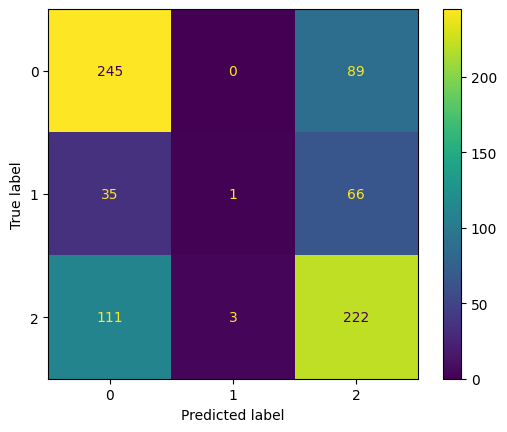

In [439]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(testy, pred)).plot()

In [440]:
probs = clf.predict_proba(fdata.values)
pred_vars = probs[:,0] * probs[:, 1] * probs[:, 2]
preds = clf.predict(fdata.values)
px.histogram(pred_vars)

In [444]:
prediction_inds = pred_vars < 0.05
fig = px.scatter(x=labeled_df.index[prediction_inds], y=labeled_df['Close'][prediction_inds], color=preds[prediction_inds])
fig.add_trace(px.line(y=labeled_df['Close']).data[0])

In [232]:
labeled_df['pred'] = preds

In [233]:
labeled_df

,Date,Open,High,Low,Close,Adj Close,Volume,Label,Signal,pred
0,2000-01-03,0.936384,1.004464,0.907924,0.999442,0.848323,535796800,None,None,0
1,2000-01-04,0.966518,0.987723,0.903460,0.915179,0.776801,512377600,None,None,2
2,2000-01-05,0.926339,0.987165,0.919643,0.928571,0.788168,778321600,None,None,2
3,2000-01-06,0.947545,0.955357,0.848214,0.848214,0.719961,767972800,None,None,2
4,2000-01-07,0.861607,0.901786,0.852679,0.888393,0.754065,460734400,None,None,0
...,...,...,...,...,...,...,...,...,...,...
5782,2022-12-23,130.919998,132.419998,129.639999,131.860001,131.299820,63814900,1,None,1
5783,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.477585,69007800,1,None,2
5784,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.504539,85438400,1,None,2
5785,2022-12-29,127.989998,130.479996,127.730003,129.610001,129.059372,75703700,None,None,1
